# Mock mid-term exam: April 2023

The objectives of this mock mid-term exam are:
- to gain acquaintance with the type of programming questions that you will be asked during the mid-term exam
- Becoming more comfortable in performing Input-Output analysis calculations

We are accounting that you will need around 100-120 minutes to complete the assignment

Please ensure that you run each cell (ctrl+enter) so that your inputs are saved 

## Data preparation: Download and import exiobase data - year 2015, industry-by-industry format

In [1]:
_# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

_# Import MRIO variables
filename = "IOT_2015_ixi"   
file_path = "data/%s" % (filename)
A = pd.read_csv('data/%s/A.txt' % (filename), sep='\t', index_col=[0, 1], header=[0, 1])
Y = pd.read_csv('data/%s/Y.txt' % (filename), sep='\t', index_col=[0, 1], header=[0, 1])
F1 = pd.read_csv('data/%s/satellite/F.txt' % (filename), sep='\t', index_col=[0], header=[0, 1])
F1_hh = pd.read_csv('data/%s/satellite/F_y.txt' % (filename), sep='\t', index_col=[0], header=[0, 1])
F2 = pd.read_csv('data/%s/impacts/F.txt' % (filename), sep='\t', index_col=[0], header=[0, 1])
F2_hh = pd.read_csv('data/%s/impacts/F_y.txt' % (filename), sep='\t', index_col=[0], header=[0, 1])

_# Import population data
pop_all = pd.read_excel('data/exiobase_PopulationGDP_1995_2019.xlsx',sheet_name='Population', index_col=[0, 1, 2], header=0)
pop = pop_all.loc[:,'y2015'];
pop = pop.droplevel([0,1], axis=0) # drop unnecessary indexes

_# Create labels (r=number of regions; s=number of sectors)
A_labels = A.columns.to_frame(index=None)
region_labels = A_labels.region.drop_duplicates().reset_index(drop=True)
sector_labels = A_labels.sector.drop_duplicates().reset_index(drop=True)
r = region_labels.shape[0]
s = sector_labels.shape[0]

_# Quick checks
print(A.shape)
print(Y.shape)
print(F1.shape)
print(F1_hh.shape)
print(F2.shape)
print(F2_hh.shape)
print(s)
print(r)
print(pop.shape)

(7987, 7987)
(7987, 343)
(1113, 7987)
(1113, 343)
(126, 7987)
(126, 343)
163
49
(49,)


In [2]:
_# Calculate the rest of MRIO variables
I = np.identity(r*s)
L = np.linalg.inv(I-A)
x = L @ Y.sum(axis=1)

x_ = x.copy()
x_[x_!=0] = 1/x_[x_!=0]
inv_diag_x_ = np.diag(x_)
S1 = F1 @ inv_diag_x_ #S1 and S2 are two definitions of the extensions per unit using the extension data from the (i) satellites and (ii)impacts folder
S2 = F2 @ inv_diag_x_

_# Quick checks
print(I.shape)
print(L.shape)
print(x.shape)
print(S1.shape)
print(S2.shape)

(7987, 7987)
(7987, 7987)
(7987,)
(1113, 7987)
(126, 7987)


In [3]:
A_labels = A.columns.to_frame(index=None)
region_labels = A_labels.region.drop_duplicates().reset_index(drop=True)
sector_labels = A_labels.sector.drop_duplicates().reset_index(drop=True)
r = region_labels.shape[0]
s = sector_labels.shape[0]

_# Aggregate Y and F_hh
Yt = np.zeros((r*s,r))
F1_hht = np.zeros((F1_hh.values.shape[0],r))
F2_hht = np.zeros((F2_hh.values.shape[0],r))

values = range(r)
for i in values:
    Yt[:,i]=Y.loc[:,region_labels[i]].sum(axis=1)
    F1_hht[:,i]=F1_hh.loc[:,region_labels[i]].sum(axis=1)
    F2_hht[:,i]=F2_hh.loc[:,region_labels[i]].sum(axis=1)
    
_#Alternative method: using the groupby function. A bit tricky because of the MultiIndex, but way more concise.
#Yt2 = Y.groupby(level=0, axis=1).sum().values
#F1_hht2 = F1_hh.groupby(level=0, axis=1).sum().values
#F2_hht2 = F2_hh.groupby(level=0, axis=1).sum().values

#Note: This method leads to a tiny difference compared to the first one for F1_hh and F2_hh, but not for Yt

_# Quick checks
print(Yt.shape)
print(Yt.sum()-Y.values.sum())
print(F1_hht.shape)
print(F1_hht.sum()-F1_hh.values.sum())
print(F2_hht.shape)
print(F2_hht.sum()-F2_hh.values.sum())

(7987, 49)
4.470348358154297e-08
(1113, 49)
0.0
(126, 49)
0.0


## Question 1: Carbon footprint of the nations (18 points)

#### 1.1 What were the per capita carbon footprint of each of the 49 exiobase regions when considering only CO2 emissions in 2015? (8 points)

(7987,)
(49,)


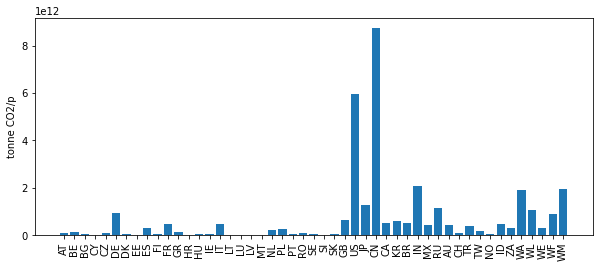

In [4]:
_# emission coefficient
fco2=S1[S1.index.str.contains("CO2")].sum(axis=0)
hh_co2t=F1_hht[F1_hh.index.str.contains("CO2")].sum(axis=0)

_# Quick checks
print(fco2.shape)
print(hh_co2t.shape)

_# Footprint calculation
e_co2 = fco2 @ L @ Yt + hh_co2t
e_co2_pp = e_co2/pop/1000     #convert the unit from kg to metric ton/capita

_# Quick check
plt.figure(figsize=(10,4))
plt.bar(region_labels,e_co2)
plt.xticks(rotation=90)
plt.ylabel('tonne CO2/p')
plt.show()

#### 1.2 What were the per capita carbon footprint of each of the 49 regions in CO2e when considering CH4, N2O, and CO2? (6 points)
Instruction: Please use 29.8 and 273 for GWP100 of CH4 and N2O, respectively.

(7987,)
(49,)


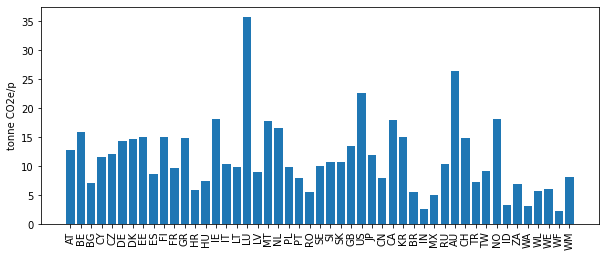

In [5]:
_# emission coefficient
fghg=S1[S1.index.str.contains("CO2")].sum(axis=0) + S1[S1.index.str.contains("CH4")].sum(axis=0)*29.8 + S1[S1.index.str.contains("N2O")].sum(axis=0)*273
hh_ghgt=F1_hht[F1_hh.index.str.contains("CO2")].sum(axis=0) + F1_hht[F1_hh.index.str.contains("CH4")].sum(axis=0)*29.8 + F1_hht[F1_hh.index.str.contains("N2O")].sum(axis=0)*273

_# Quick checks
print(fghg.shape)
print(hh_ghgt.shape)

_# Footprint calculation
e_ghg = fghg@ L @ Yt + hh_ghgt
e_ghg_pp = e_ghg/pop/1000     #convert the unit from kg to metric ton/capita

_# Quick check
plt.figure(figsize=(10,4))
plt.bar(region_labels,e_ghg_pp)
plt.xticks(rotation=90)
plt.ylabel('tonne CO2e/p')
plt.show()

#### 1.3 How dominant are CO2 emissions in each region's carbon footprint measured in CO2e? (4 points)

0.8442585759260715
0.3722561994383321


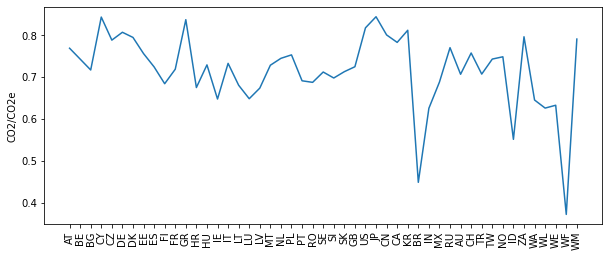

In [6]:
print(max(e_co2_pp/e_ghg_pp))
print(min(e_co2_pp/e_ghg_pp))

_# Quick check
plt.figure(figsize=(10,4))
plt.plot(region_labels,e_co2_pp/e_ghg_pp)
plt.xticks(rotation=90)
plt.ylabel('CO2/CO2e')
plt.show()

CO2 accounts for 37% to 84% of the countries'/regions' GHG footprints in 2015. Aside from a few outliers (Brasil, Rest of Africa, India), more than 60% of the regions' footprints is coming from CO2.

## Question 2: Territorial emissions (6 points)

#### 2.1 What were the per capita territorial emissions of the US and China, respectively, in 2015? Only consider CO2 emissions here. (6 points)

(49,)
0.0
[5.14547880e+12 9.92962757e+12]


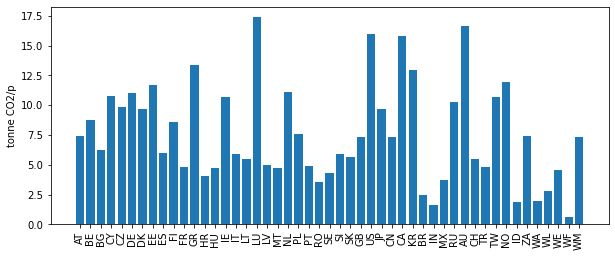

In [7]:
e_co2_pba = np.diag(fco2) @ x
e_co2_pba = e_co2_pba.reshape((r,s)).sum(1) + hh_co2t

_# Quick checks
print(e_co2_pba.shape)
print(e_co2_pba.sum()-e_co2.sum())

e_co2_pba_pp=e_co2_pba/pop/1000 #convert unit from kg to tonne/capita
print(e_co2_pba[[28,30]]) #After opening the file (or use print(region_labels.index)), we see that US and CN are tied to the indices 28 and 30.

_# Quick check
plt.figure(figsize=(10,4))
plt.bar(region_labels,e_co2_pba_pp)
plt.xticks(rotation=90)
plt.ylabel('tonne CO2/p')
plt.show()

## Question 3: Emissions embodied in trade (20 points)

### 3.1 Were the US and China net importers or exporters of CO2 emissions in 2015? (4 points)

In [8]:
net_import = (e_co2 - e_co2_pba)*1e-9 # convert from kg to million metric ton
print(net_import[[28,30]])

[  826.36788266 -1194.15902093]


The US was a net importer of 826 MtCO2 and China was a net exporter of 1194 MtCO2 in 2015

#### 3.2 Which were the top three regional contributers of US' and China's carbon footprints (only consider CO2 emissions), respectively, in 2015? (12 points)

(7987, 49)
0.0


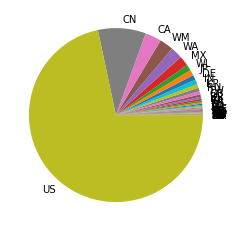

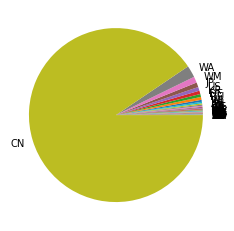

In [9]:
temp = np.diag(fco2) @ L @ Yt

print(temp.shape)
_#Aggregating the rows
EET = np.zeros((r,r))
values = range(r)
for i in values:
    start_i=i*s
    end_i=start_i+s
    EET[i,:]=temp[start_i:end_i,:].sum(axis=0)
    
#Alternative:
#EET2 = pd.DataFrame(temp, index=A.index, columns=region_labels)
#EET2 = EET2.groupby(level=0, axis=0).sum()
#print(EET2.values.sum()-EET.sum()) #Shows the slight difference in results of the two methods, again


_#Check the aggregations
print(EET.sum()-temp.sum())

_# Quick check
for i in [28,30]:
    EET_i=EET[:,i]
    order=np.argsort(EET_i)      # return the index of the sorted geographic sources
    plt.pie(EET_i[order],labels=region_labels[order])
    plt.show()


#### 3.3 By conducting emissions emoboided in trade calculations, how much CO2 emissions did the US outsourced to China in 2015? (4 points)

In [10]:
e_co2_uscn=(EET[30,28]-EET[28,30])*1e-9   # in million metric tons 

The US net outsourced 339 Mt CO2 emissions from China in 2015

## Question 4 Environmental vs Economic Footprints Analysis (16 points)

#### 4.1 Using the "impact" accounts, what were the value added footprints of the US and China, respectively, in 2015? (8 points)

In [11]:
_# va coefficient
fva=S2[S2.index.str.contains("Value Added")].sum(axis=0)
hh_vat=F2_hht[F2_hh.index.str.contains("Value Added")].sum(axis=0)

_# Quick checks
print(fva.shape)
print(hh_vat.shape)

_# VA footprint calculation
e_va = fva @ L @ Yt + hh_vat
e_va_pp = e_va/pop*1e6      #convert the unit from million euros/p to euros/p
print(e_va_pp[[28,30]])

(7987,)
(49,)
US    52445.887193
CN     7107.782845
Name: y2015, dtype: float64


#### 4.2 Make two main observations on the carbon vs value added footprint results regarding the relationships between the US and China? Please refer to the carbon footprint results obtained in Question 1 (8 points)

125352.43557258399
-1.4901161193847656e-08


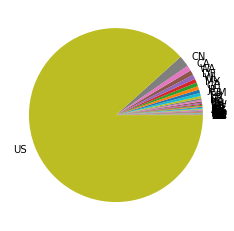

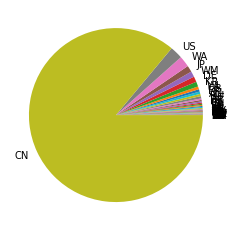

In [13]:
#An option is to perform the same analysis of calculating the outsourcing of va instead of CO2 and compare both.

_# Bringing out the geographic sources of the countries' value added outsourcing
temp = np.diag(fva) @ L @ Yt

_#Aggregating the rows
EET_va = np.zeros((r,r))
values = range(r)
for i in values:
    start_i=i*s
    end_i=start_i+s
    EET_va[i,:]=temp[start_i:end_i,:].sum(axis=0)
    
_# US' net value added outsourcing from China
e_va_uscn=(EET_va[30,28]-EET_va[28,30])       # in million euros
print(e_va_uscn)

_#Check the aggregations
print(EET_va.sum()-temp.sum())

_# Quick check
for i in [28,30]:
    EET_i=EET_va[:,i]
    order=np.argsort(EET_i)
    plt.pie(EET_i[order],labels=region_labels[order])
    plt.show()
